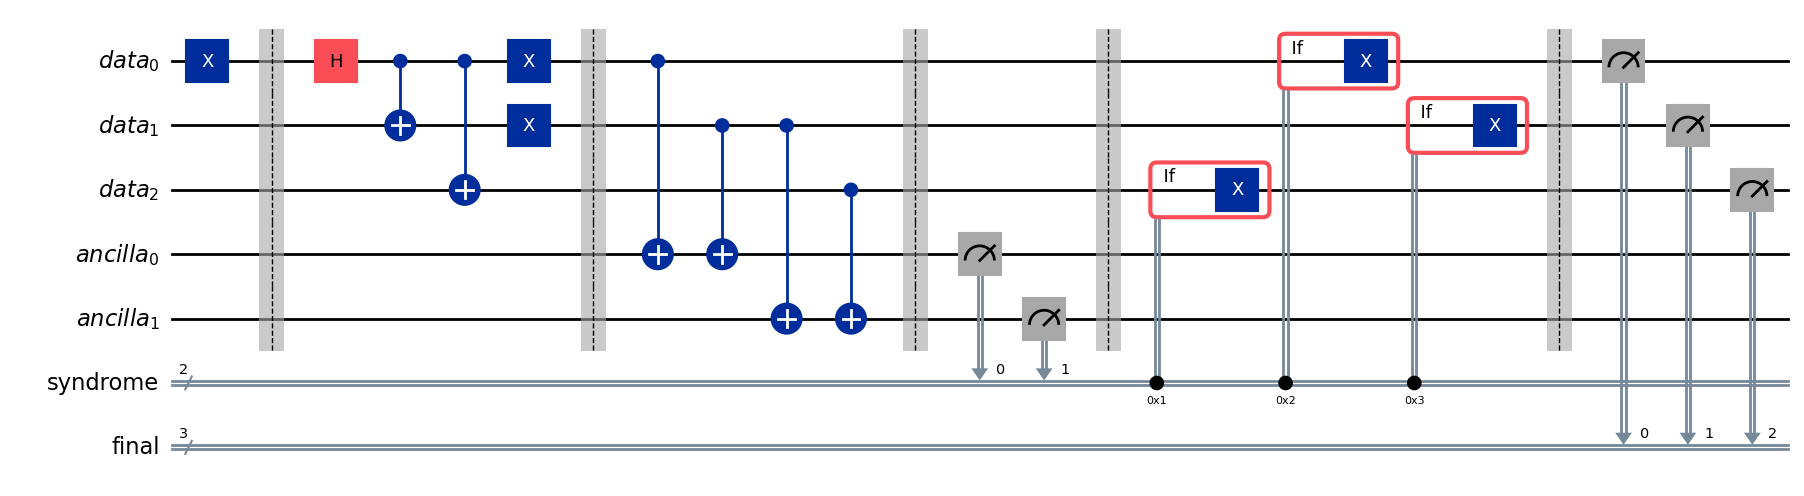


Measurement results:
Syndrome: 01, Final state: 0 01, Count: 505
Syndrome: 10, Final state: 1 01, Count: 495


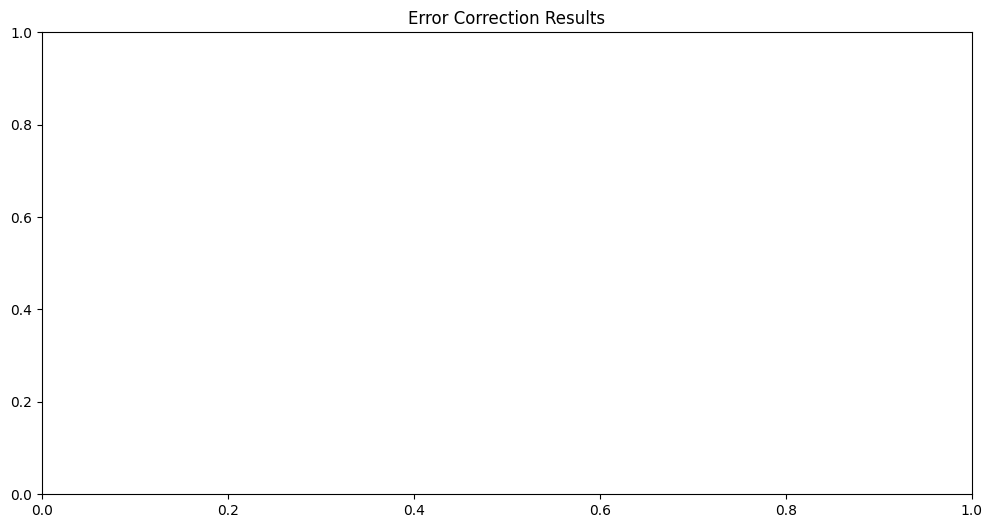

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import numpy as np
import matplotlib.pyplot as plt

def create_error_correction_circuit(error_prob=0.8):
    # Create quantum registers
    data = QuantumRegister(3, 'data')    # 3 data qubits
    ancilla = QuantumRegister(2, 'ancilla')  # 2 ancilla qubits
    syndrome = ClassicalRegister(2, 'syndrome')  # 2 classical bits for syndrome measurement
    final = ClassicalRegister(3, 'final')  # 3 classical bits for final state
    qc = QuantumCircuit(data, ancilla, syndrome, final)
    
    # Initialize the first data qubit to |1⟩
    qc.x(data[0])
    
    # Encoding: Create GHZ state
    qc.barrier()
    qc.h(data[0])
    qc.cx(data[0], data[1])
    qc.cx(data[0], data[2])
    
    # Add some noise (bit-flip) with probability error_prob
    for i in range(3):
        if np.random.random() < error_prob:
            qc.x(data[i])
    
    # Error Detection using ancilla qubits
    qc.barrier()
    # First syndrome measurement
    qc.cx(data[0], ancilla[0])
    qc.cx(data[1], ancilla[0])
    # Second syndrome measurement
    qc.cx(data[1], ancilla[1])
    qc.cx(data[2], ancilla[1])
    
    # Measure syndrome
    qc.barrier()
    qc.measure(ancilla, syndrome)
    
    # Error Correction based on syndrome measurement
    qc.barrier()
    with qc.if_test((syndrome, 1)):  # syndrome = 01
        qc.x(data[2])
    with qc.if_test((syndrome, 2)):  # syndrome = 10
        qc.x(data[0])
    with qc.if_test((syndrome, 3)):  # syndrome = 11
        qc.x(data[1])
    
    # Measure final state
    qc.barrier()
    qc.measure(data, final)
    
    return qc

def run_error_correction(shots=1000):
    # Create and run the circuit
    qc = create_error_correction_circuit()
    
    # Initialize simulator
    simulator = AerSimulator()
    
    # Execute the circuit
    job = simulator.run(qc, shots=shots)
    result = job.result()
    
    return result.get_counts()

# Example usage
if __name__ == "__main__":
    # Create and display circuit
    qc = create_error_correction_circuit()
    
    # Display circuit
    display(circuit_drawer(qc, output="mpl"))
    
    # Run circuit and get results
    counts = run_error_correction(shots=1000)
    
    # Display results
    print("\nMeasurement results:")
    for state, count in counts.items():
        syndrome = state[:2]  # First two bits are syndrome
        final = state[2:]     # Last three bits are final state
        print(f"Syndrome: {syndrome}, Final state: {final}, Count: {count}")
    
    # Plot histogram of results
    fig = plt.figure(figsize=(12, 6))
    plot_histogram(counts)
    plt.title("Error Correction Results")
    plt.show()